In [135]:
import pyupbit
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_row', 1460)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings(action='ignore')

## 터틀 알고리즘
- 설명 : 시세가 4주 동안의 최고치를 경신하면 롱 포지션 진입, 반대로 시세가 2주 동안의 최저치를 경신하면 숏 포지션 진입
  

In [ ]:
def get_high_price(df, idx, term): 
    test_price = df.iloc[idx].high
    df = df[idx - term: idx].high
    price_ordering = []
    
    for price in df:
        if price > test_price:
            return False
        
        price_ordering.append(price)
        
    return max(price_ordering)


def get_low_price(df, idx, term):
    test_price = df.iloc[idx].low
    df = df[idx - term: idx].low
    price_ordering = []
    
    for price in df:
        if price < test_price:
            return False
        
        price_ordering.append(price)
    
    return min(price_ordering)

params = [3, 4, 5, 7, 10, 15, 20, 30, 40]
params_result = []
for param in params:
    position = 0 
    position_list = []
    postion_price_list = []
    count = 0
    for idx, data in enumerate(df[param:].itertuples(), long_param):
        if position == 0:
            if result := get_high_price(df, idx, long_param):
                position = 1
                position_list.append(position)
                postion_price_list.append(result)
                count += 1

            elif result := get_low_price(df, idx, short_param):
                position = 2
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)

        elif position == 1:
            if result := get_low_price(df, idx, short_param):
                position = 2
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)

        elif position == 2:
            if result := get_high_price(df, idx, long_param):
                position = 1
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)


    df = df[long_param:].copy()
    df['position'] = position_list
    df['position_price'] =postion_price_list


    df = df.replace(np.nan, 0, regex=True)

    daily_rr = list(map(lambda x: set_price(x), df.itertuples()))


    df['daily_rr'] = daily_rr
    df = df.dropna()
    df['hpr'] = df['daily_rr'].cumprod()
    df['nr'] = df['close'] / df['open'] # normal rate
    df['n_hpr'] = df['nr'].cumprod() 
    df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
    df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100

    params_result.append({"long_param": long_param, 
                   "short_param": short_param, 
                   "mdd": round(df['mdd'].max(), 2),
                   "hpr": round(df['hpr'].iloc[-1] * 100, 2)})
    

In [100]:
def get_high_price(df, idx, term): 
    test_price = df.iloc[idx].high
    df = df[idx - term: idx].high
    price_ordering = []
    
    for price in df:
        if price > test_price:
            return False
        
        price_ordering.append(price)
        
    return max(price_ordering)


def get_low_price(df, idx, term):
    test_price = df.iloc[idx].low
    df = df[idx - term: idx].low
    price_ordering = []
    
    for price in df:
        if price < test_price:
            return False
        
        price_ordering.append(price)
    
    return min(price_ordering)

def visualize_return_rate(df):
    plt.figure(figsize = (20, 8))
    plt.plot(df.index, df['hpr']*100, color = 'r')
    plt.plot(df.index, df['n_hpr']*100, color = 'k', linestyle = '--')
    plt.legend(loc='best')
    plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
                return_rate: {round(df['hpr'].iloc[-1] * 100, 2)}%")
    plt.ylabel("rate of return")
    plt.grid(True)
    plt.show()

def set_price(x):
    result = None

    if x.position == 1:
        if x.position_price:
            result = (x.open / x.position_price) * (x.close / x.position_price)
        else:
            result = x.close / x.open
            
    elif x.position == 2:
        if x.position_price:
            result = (x.position_price / x.open) * (x.position_price / x.close) 
        else:
            result = x.open / x.close
        
    return result



df = pyupbit.get_ohlcv(ticker="KRW-DOGE", interval="1d", to="2021-11-09", count=200)

params = [(3, 3) , (4, 4), (5, 5), (10, 10), (14, 14), (20, 20), (30, 30)]
params_result = []
for long_param, short_param in params:  
    position = 0 
    position_list = []
    postion_price_list = []
    count = 0
    for idx, data in enumerate(df[long_param:].itertuples(), long_param):

        if position == 0:
            if result := get_high_price(df, idx, long_param):
                position = 1
                position_list.append(position)
                postion_price_list.append(result)
                count += 1

            elif result := get_low_price(df, idx, short_param):
                position = 2
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)

        elif position == 1:
            if result := get_low_price(df, idx, short_param):
                position = 2
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)

        elif position == 2:
            if result := get_high_price(df, idx, long_param):
                position = 1
                position_list.append(position)
                postion_price_list.append(result)
                count += 1
            else:
                position_list.append(position)
                postion_price_list.append(None)


    df = df[long_param:].copy()
    df['position'] = position_list
    df['position_price'] =postion_price_list


    df = df.replace(np.nan, 0, regex=True)

    daily_rr = list(map(lambda x: set_price(x), df.itertuples()))


    df['daily_rr'] = daily_rr
    df = df.dropna()
    df['hpr'] = df['daily_rr'].cumprod()
    df['nr'] = df['close'] / df['open'] # normal rate
    df['n_hpr'] = df['nr'].cumprod() 
    df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
    df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100

    params_result.append({"long_param": long_param, 
                   "short_param": short_param, 
                   "mdd": round(df['mdd'].max(), 2),
                   "hpr": round(df['hpr'].iloc[-1] * 100, 2)})
    

No handles with labels found to put in legend.


{'long_param': 3, 'short_param': 3, 'mdd': 49.03, 'hpr': 157.53}
{'long_param': 4, 'short_param': 4, 'mdd': 48.1, 'hpr': 187.74}
{'long_param': 5, 'short_param': 5, 'mdd': 43.77, 'hpr': 139.25}
{'long_param': 10, 'short_param': 10, 'mdd': 42.3, 'hpr': 83.22}
{'long_param': 14, 'short_param': 14, 'mdd': 30.8, 'hpr': 207.19}
{'long_param': 20, 'short_param': 20, 'mdd': 30.76, 'hpr': 109.82}
{'long_param': 30, 'short_param': 30, 'mdd': 44.69, 'hpr': 73.19}


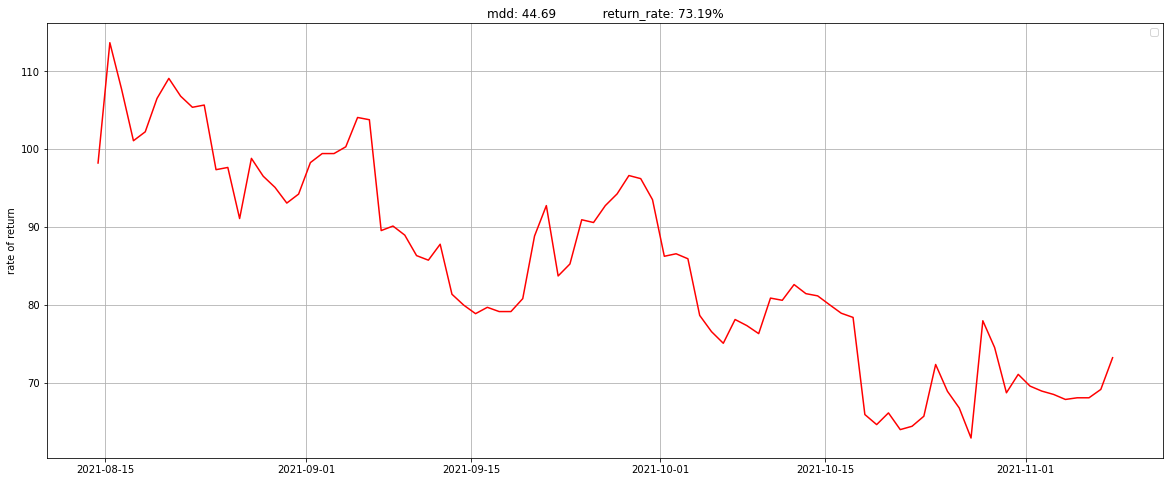

In [101]:
for r in params_result:
    print(r)

plt.figure(figsize = (20, 8))
plt.plot(df.index, df['hpr']*100, color = 'r')
plt.legend(loc='best')
plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
            return_rate: {round(df['hpr'].iloc[-1] * 100, 2)}%")
plt.ylabel("rate of return")
plt.grid(True)
plt.show()

In [11]:
df

,open,high,low,close,volume,value,position,position_price,daily_rr,hpr,nr,n_hpr,mdd,n_mdd
2021-05-19 09:00:00,10810.0,11000.0,5725.0,7545.0,5.974136e+06,5.135957e+10,2,7065.0,0.611983,0.611983,0.697965,0.697965,0.000000,0.000000
2021-05-20 09:00:00,7550.0,9255.0,6795.0,8445.0,4.798598e+06,3.799519e+10,2,0.0,0.894020,0.547125,1.118543,0.780704,10.597987,0.000000
2021-05-21 09:00:00,8460.0,9180.0,6565.0,7455.0,4.420353e+06,3.555875e+10,2,0.0,1.134809,0.620882,0.881206,0.687961,0.000000,11.879433
2021-05-22 09:00:00,7455.0,7485.0,6000.0,6575.0,2.902913e+06,1.938481e+10,2,0.0,1.133840,0.703982,0.881958,0.606753,0.000000,22.281324
2021-05-23 09:00:00,6575.0,6930.0,4265.0,5275.0,4.324267e+06,2.440836e+10,2,0.0,1.246445,0.877475,0.802281,0.486786,0.000000,37.647754
2021-05-24 09:00:00,5275.0,8505.0,5015.0,7565.0,7.381741e+07,5.502649e+11,2,0.0,0.697290,0.611854,1.434123,0.698112,30.270985,10.579196
2021-05-25 09:00:00,7565.0,8090.0,6820.0,7545.0,9.959874e+06,7.442512e+10,2,0.0,1.002651,0.613476,0.997356,0.696266,30.086150,10.815603
2021-05-26 09:00:00,7560.0,9425.0,7505.0,8700.0,3.222511e+07,2.800976e+11,2,0.0,0.868966,0.533090,1.150794,0.801258,39.247275,0.000000
2021-05-27 09:00:00,8700.0,10340.0,8610.0,8785.0,2.800320e+07,2.603401e+11,2,0.0,0.990324,0.527932,1.009770,0.809087,39.835093,0.000000
2021-05-28 09:00:00,8780.0,8900.0,7240.0,7695.0,8.119988e+06,6.460405e+10,2,0.0,1.141001,0.602371,0.876424,0.709103,31.351802,12.357631


No handles with labels found to put in legend.


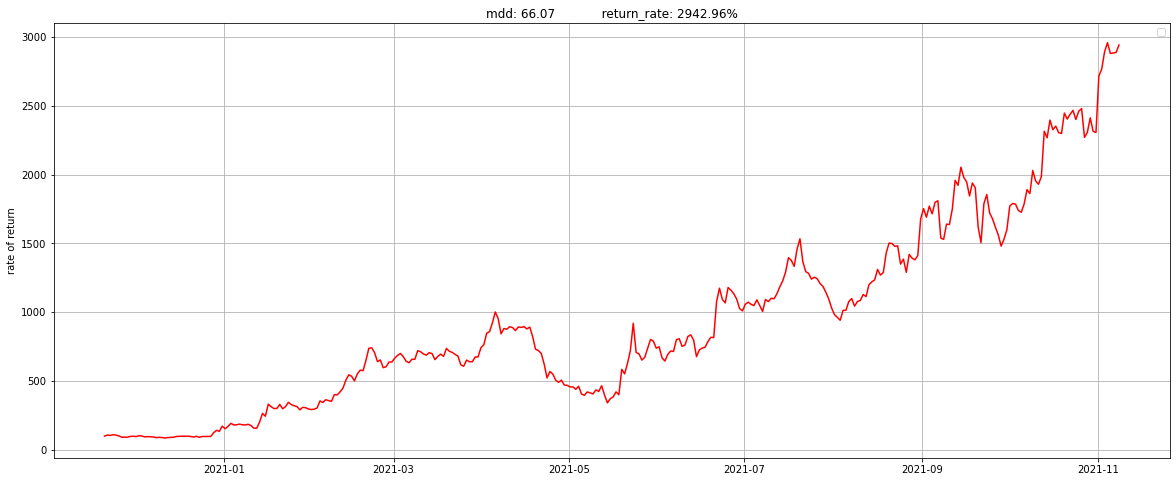

In [133]:
df = pyupbit.get_ohlcv(ticker="KRW-DOT", interval="1d", to="2021-11-09", count=1000)
position = 0 
position_list = []
postion_price_list = []
count = 0

long_param = 30
short_param = 30

for idx, data in enumerate(df[long_param:].itertuples(), long_param):

    if position == 0:
        if result := get_high_price(df, idx, long_param):
            position = 1
            position_list.append(position)
            postion_price_list.append(result)
            count += 1

        elif result := get_low_price(df, idx, short_param):
            position = 2
            position_list.append(position)
            postion_price_list.append(result)
            count += 1
        else:
            position_list.append(position)
            postion_price_list.append(None)

    elif position == 1:
        if result := get_low_price(df, idx, short_param):
            position = 2
            position_list.append(position)
            postion_price_list.append(result)
            count += 1
        else:
            position_list.append(position)
            postion_price_list.append(None)

    elif position == 2:
        if result := get_high_price(df, idx, long_param):
            position = 1
            position_list.append(position)
            postion_price_list.append(result)
            count += 1
        else:
            position_list.append(position)
            postion_price_list.append(None)


df = df[long_param:].copy()
df['position'] = position_list
df['position_price'] =postion_price_list


df = df.replace(np.nan, 0, regex=True)

daily_rr = list(map(lambda x: set_price(x), df.itertuples()))


df['daily_rr'] = daily_rr
df = df.dropna()
df['hpr'] = df['daily_rr'].cumprod()
df['nr'] = df['close'] / df['open'] # normal rate
df['n_hpr'] = df['nr'].cumprod() 
df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100


df = df.copy()
plt.figure(figsize = (20, 8))
plt.plot(df.index, df['hpr']*100, color = 'r')
plt.legend(loc='best')
plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
            return_rate: {round(df['hpr'].iloc[-1] * 100, 2)}%")
plt.ylabel("rate of return")
plt.grid(True)
plt.show()

In [134]:
df

,open,high,low,close,volume,value,position,position_price,daily_rr,hpr,nr,n_hpr,mdd,n_mdd
2020-11-20 09:00:00,5295.0,6050.0,5285.0,5770.0,6.186939e+05,3.591121e+09,1,5605.0,0.972502,0.972502,1.089707,1.089707,0.000000,0.000000
2020-11-21 09:00:00,5785.0,6365.0,5680.0,6280.0,3.047959e+05,1.817989e+09,1,0.0,1.085566,1.055715,1.085566,1.182949,0.000000,0.000000
2020-11-22 09:00:00,6285.0,6335.0,5625.0,6075.0,2.707853e+05,1.631213e+09,1,0.0,0.966587,1.020441,0.966587,1.143424,3.341289,3.341289
2020-11-23 09:00:00,6075.0,6505.0,5965.0,6420.0,3.453870e+05,2.158540e+09,1,0.0,1.056790,1.078392,1.056790,1.208359,0.000000,0.000000
2020-11-24 09:00:00,6475.0,6730.0,6105.0,6305.0,3.959769e+05,2.548998e+09,1,0.0,0.973745,1.050079,0.973745,1.176633,2.625483,2.625483
2020-11-25 09:00:00,6305.0,6405.0,5765.0,5925.0,3.388310e+05,2.067317e+09,1,0.0,0.939730,0.986791,0.939730,1.105718,8.494208,8.494208
2020-11-26 09:00:00,5920.0,5975.0,5020.0,5390.0,3.673687e+05,2.011992e+09,1,0.0,0.910473,0.898446,0.910473,1.006727,16.686450,16.686450
2020-11-27 09:00:00,5400.0,5660.0,5035.0,5375.0,2.533527e+05,1.363448e+09,1,0.0,0.995370,0.894287,0.995370,1.002066,17.072161,17.072161
2020-11-28 09:00:00,5375.0,5445.0,5230.0,5385.0,2.001387e+05,1.071664e+09,1,0.0,1.001860,0.895951,1.001860,1.003930,16.917876,16.917876
2020-11-29 09:00:00,5385.0,5745.0,5275.0,5730.0,2.826582e+05,1.551504e+09,1,0.0,1.064067,0.953352,1.064067,1.068249,11.595066,11.595066


In [572]:
ETH_df['datetime'] = ETH_df.index
print(round(ETH_df['mdd'].max(), 2))

51.88


In [574]:
BTC_df['datetime'] = BTC_df.index
print(round(BTC_df['mdd'].max(), 2))

53.45


In [576]:
ADA_df['datetime'] = ADA_df.index
print(round(ADA_df['mdd'].max(), 2))

51.66


In [570]:
XRP_df['datetime'] = XRP_df.index
print(round(XRP_df['mdd'].max(), 2))

70.16


In [577]:
df = pd.merge(left=ETH_df, right=XRP_df, how="left", on="datetime")
df = pd.merge(left=df, right=ADA_df, how="left", on="datetime")
# df = pd.merge(left=df, right=DOGE_df, how="left", on="datetime")
df = pd.merge(left=df, right=BTC_df, how="left", on="datetime")

In [578]:
df

,open_x,high_x,low_x,close_x,volume_x,value_x,position_x,position_price_x,daily_rr_x,hpr_x,nr_x,n_hpr_x,mdd_x,n_mdd_x,datetime,open_y,high_y,low_y,close_y,volume_y,value_y,position_y,position_price_y,daily_rr_y,hpr_y,nr_y,n_hpr_y,mdd_y,n_mdd_y,open_x,high_x,low_x,close_x,volume_x,value_x,position_x,position_price_x,daily_rr_x,hpr_x,nr_x,n_hpr_x,mdd_x,n_mdd_x,open_y,high_y,low_y,close_y,volume_y,value_y,position_y,position_price_y,daily_rr_y,hpr_y,nr_y,n_hpr_y,mdd_y,n_mdd_y
0,568100.0,576100.0,305000.0,554500.0,67870.449187,3.816908e+10,2,438950.0,0.611651,0.611651,0.976061,0.976061,0.000000,0.000000,2017-12-06 09:00:00,292.0,300.0,281.0,290.0,3.183609e+07,9.243546e+09,2,0.0,1.006897,0.789508,0.993151,1.055931,32.406589,14.653364,158.0,174.0,150.0,157.0,9.287015e+08,1.473691e+11,1,0.0,0.993671,4.069374,0.993671,5.161987,0.632911,0.632911,14645000.0,19006000.0,14645000.0,18390000.0,46874.815723,7.644868e+11,1,0.0,1.255719,0.904717,1.255719,2.430023,13.174628,0.000000
1,554500.0,597800.0,518900.0,586500.0,60978.938191,3.424302e+10,2,0.0,0.945439,0.578279,1.057710,1.032389,5.456095,0.000000,2017-12-07 09:00:00,289.0,297.0,267.0,287.0,2.562037e+07,7.353272e+09,2,0.0,1.006969,0.795010,0.993080,1.048624,31.935555,15.243998,157.0,171.0,142.0,145.0,6.978612e+08,1.094894e+11,2,148.0,0.962179,3.915465,0.923567,4.767440,4.391096,8.227848,18389000.0,23860000.0,17965000.0,23791000.0,55171.056944,1.118270e+12,1,0.0,1.293763,1.170489,1.293763,3.143873,0.000000,0.000000
2,586500.0,600000.0,512000.0,564200.0,55715.369318,3.145684e+10,2,0.0,1.039525,0.601135,0.961978,0.993135,1.719248,3.802217,2017-12-08 09:00:00,287.0,411.0,271.0,298.0,1.775824e+08,5.848709e+10,1,346.0,0.714407,0.567961,1.038328,1.088815,51.374255,11.995510,145.0,153.0,106.0,144.0,8.606109e+08,1.165385e+11,2,0.0,1.006944,3.942656,0.993103,4.734561,3.727145,8.860759,23795000.0,24967000.0,16521000.0,20260000.0,101681.962251,2.070532e+12,1,0.0,0.851439,0.996600,0.851439,2.676817,14.856062,14.856062
3,564200.0,596000.0,517500.0,553500.0,92933.678588,5.230311e+10,2,0.0,1.019332,0.612756,0.981035,0.974300,0.000000,5.626598,2017-12-09 09:00:00,298.0,309.0,270.0,284.0,4.135699e+07,1.196713e+10,1,0.0,0.953020,0.541278,0.953020,1.037662,53.658686,16.129949,144.0,159.0,130.0,139.0,5.270755e+08,7.580124e+10,2,0.0,1.035971,4.084478,0.965278,4.570166,0.264093,12.025316,20259000.0,20877000.0,15257000.0,17769000.0,57286.612720,1.017294e+12,1,0.0,0.877092,0.874110,0.877092,2.347814,25.320962,25.320962
4,553500.0,558700.0,446400.0,504000.0,113385.900098,5.518776e+10,2,0.0,1.098214,0.672938,0.910569,0.887168,0.000000,14.066496,2017-12-10 09:00:00,284.0,286.0,240.0,269.0,4.947914e+07,1.292233e+10,2,267.0,0.933151,0.505094,0.947183,0.982856,56.756558,20.559706,140.0,141.0,101.0,126.0,6.418402e+08,7.785320e+10,2,0.0,1.111111,4.538309,0.900000,4.113150,0.000000,20.822785,17769000.0,18537000.0,13744000.0,17661000.0,87737.901801,1.397577e+12,2,15257000.0,0.741754,0.648375,0.993922,2.333544,44.606510,25.774861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,5460000.0,5487000.0,5372000.0,5450000.0,37988.508680,2.059794e+11,1,0.0,0.998168,481.020236,0.998168,9.233911,6.900126,0.183150,2021-11-04 09:00:00,1430.0,1490.0,1410.0,1445.0,3.660639e+08,5.289453e+11,1,0.0,1.010490,3840.813010,1.010490,5.620063,15.021483,64.860539,2450.0,2495.0,2365.0,2390.0,2.750525e+07,6.653561e+10,1,0.0,0.975510,89930.633672,0.975510,81.238257,49.973878,30.071430,74607000.0,74880000.0,73480000.0,73807000.0,5757.701988,4.264695e+11,1,0.0,0.989277,377.396155,0.989277,9.888002,6.893878,8.631738
1430,5450000.0,5485000.0,5396000.0,5440000.0,27849.889274,1.516295e+11,1,0.0,0.998165,480.137630,0.998165,9.216968,7.070952,0.366300,2021-11-05 09:00:00,1440.0,1445.0,1390.0,1405.0,2.109282e+08,2.990880e+11,1,0.0,0.975694,3747.459916,0.975694,5.483464,17.0

In [580]:
df[['mdd_x', 'mdd_y']]

,mdd_x,mdd_x,mdd_y,mdd_y
0,0.000000,0.632911,32.406589,13.174628
1,5.456095,4.391096,31.935555,0.000000
2,1.719248,3.727145,51.374255,14.856062
3,0.000000,0.264093,53.658686,25.320962
4,0.000000,0.000000,56.756558,44.606510
...,...,...,...,...
1429,6.900126,49.973878,15.021483,6.893878
1430,7.070952,49.450592,17.086933,6.497772
1431,6.524712,49.031095,17.968987,5.888239
1432,4.595098,48.610733,13.281501,3.414802


In [583]:
avg_hpr_list = []
for data in df[['hpr_x', 'hpr_y']].itertuples():
    avg_hpr = (data.hpr_x + data._2 + data.hpr_y + data.hpr_y + data._4) / 4
    avg_hpr_list.append(avg_hpr)

df['avg_hpr'] = avg_hpr_list
df['avg_mdd'] = (df['avg_hpr'].cummax() - df['avg_hpr']) / df['avg_hpr'].cummax() * 100

Pandas(Index=0, hpr_x=0.6116511082374942, _2=4.069373745478866, hpr_y=0.7895077676992869, _4=0.9047170583288694)
Pandas(Index=1, hpr_x=0.5782788397573582, _2=3.915465078891679, hpr_y=0.7950095639898742, _4=1.1704890714395633)
Pandas(Index=2, hpr_x=0.6011353057739995, _2=3.9426558086062045, hpr_y=0.567960740166711, _4=0.9966004869664027)
Pandas(Index=3, hpr_x=0.6127561689569838, _2=4.084477959994917, hpr_y=0.5412780208300199, _4=0.8741099784247005)
Pandas(Index=4, hpr_x=0.6729375784081162, _2=4.538308844438797, hpr_y=0.5050940995202796, _4=0.6483747484891872)
Pandas(Index=5, hpr_x=0.5772945353492606, _2=4.143673292748466, hpr_y=0.47001812038692686, _4=0.5930981733603116)
Pandas(Index=6, hpr_x=0.604562163399284, _2=3.889979009518968, hpr_y=0.3485882165158518, _4=0.6045906247659734)
Pandas(Index=7, hpr_x=0.6705923571322555, _2=3.83741172560655, hpr_y=0.41910721204089774, _4=0.6238566404260721)
Pandas(Index=8, hpr_x=0.6730792085845363, _2=5.880357986234633, hpr_y=0.7532710885629902, _4=0.6

In [584]:
print(round(df['avg_mdd'].max(), 2))

49.64


In [590]:
df[['avg_mdd', 'hpr_x']]

,avg_mdd,hpr_x,hpr_x
0,0.000000,0.611651,4.069374
1,0.000000,0.578279,3.915465
2,7.966900,0.601135,3.942656
3,8.275863,0.612756,4.084478
4,5.299550,0.672938,4.538309
5,13.787085,0.577295,4.143673
6,20.097784,0.604562,3.889979
7,17.702403,0.670592,3.837412
8,0.000000,0.673079,5.880358
9,7.322021,0.662440,5.452286


No handles with labels found to put in legend.


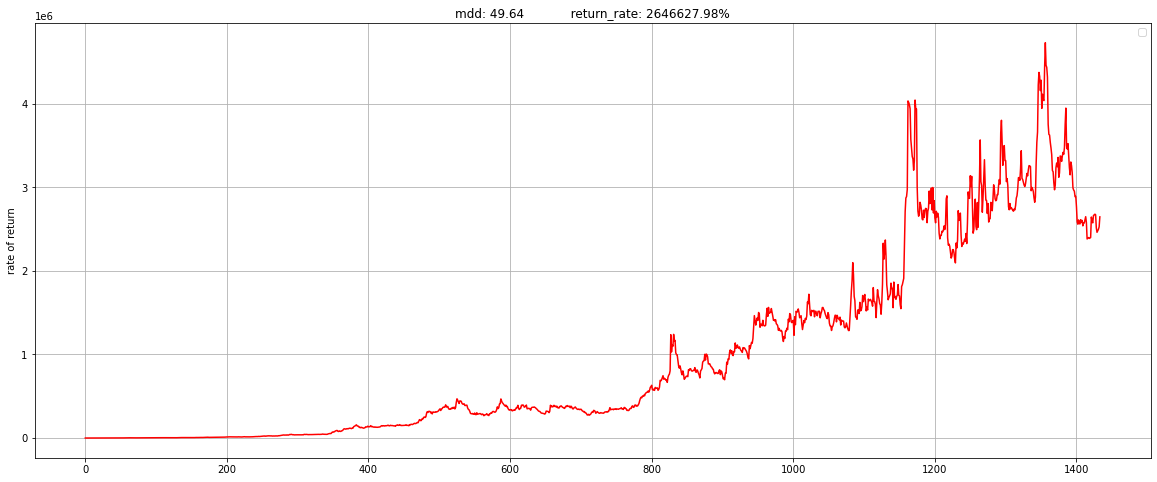

In [586]:
plt.figure(figsize = (20, 8))
plt.plot(df.index, df['avg_hpr']*100, color = 'r')
plt.legend(loc='best')
plt.title(f"mdd: {round(df['avg_mdd'].max(), 2)}\
            return_rate: {round(df['avg_hpr'].iloc[-1] * 100, 2)}%")
plt.ylabel("rate of return")
plt.grid(True)
plt.show()

In [591]:
import ccxt

In [630]:
auth = {"api_key": "Dt81SVf8CiRnZI6HurMfPE2L128PpufdG9aSaONfbh4qjICmtdJJfk0mFjFEine1",
             "secret": "3fSbN60xhXWzL0mrzw4Jy1NSzdGLUnPtx9XukNcgUV7XQrZE6WNZmIBCouQpkfL7"}

binance = ccxt.binance(config={
    'apiKey': auth.get("api_key"),
    'secret': auth.get("secret"),
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future'
    }
})

balance = binance.fetch_balance()


In [619]:
count = 0
for symbol in balance['info']['positions']:
    if symbol['symbol'] in ["ETHUSDT", "BTCUSDT", "XRPUSDT", "DOGEUSDT", "ADAUSDT"]:
        if symbol['initialMargin'] != '0':
            count += 1
        print(symbol)

print(count)

{'symbol': 'ADAUSDT', 'initialMargin': '0', 'maintMargin': '0', 'unrealizedProfit': '0.00000000', 'positionInitialMargin': '0', 'openOrderInitialMargin': '0', 'leverage': '1', 'isolated': False, 'entryPrice': '0.0', 'maxNotional': '9.223372036854776E18', 'positionSide': 'BOTH', 'positionAmt': '0', 'notional': '0', 'isolatedWallet': '0', 'updateTime': '0'}
{'symbol': 'ETHUSDT', 'initialMargin': '1768.21552908', 'maintMargin': '8.84107764', 'unrealizedProfit': '20.55902908', 'positionInitialMargin': '1768.21552908', 'openOrderInitialMargin': '0', 'leverage': '1', 'isolated': False, 'entryPrice': '4788.1', 'maxNotional': '5.0E8', 'positionSide': 'BOTH', 'positionAmt': '0.365', 'notional': '1768.21552908', 'isolatedWallet': '0', 'updateTime': '1636551821074'}
{'symbol': 'DOGEUSDT', 'initialMargin': '0', 'maintMargin': '0', 'unrealizedProfit': '0.00000000', 'positionInitialMargin': '0', 'openOrderInitialMargin': '0', 'leverage': '1', 'isolated': False, 'entryPrice': '0.0', 'maxNotional': '5

In [631]:
balance

{'info': {'feeTier': '0',
  'canTrade': True,
  'canDeposit': True,
  'canWithdraw': True,
  'updateTime': '0',
  'totalInitialMargin': '1643.77384310',
  'totalMaintMargin': '8.31397168',
  'totalWalletBalance': '1770.77278337',
  'totalUnrealizedProfit': '20.75584360',
  'totalMarginBalance': '1791.52862697',
  'totalPositionInitialMargin': '1643.77384310',
  'totalOpenOrderInitialMargin': '0.00000000',
  'totalCrossWalletBalance': '1770.77278337',
  'totalCrossUnPnl': '20.75584360',
  'availableBalance': '147.75143387',
  'maxWithdrawAmount': '147.75478387',
  'assets': [{'asset': 'DOT',
    'walletBalance': '0.00000000',
    'unrealizedProfit': '0.00000000',
    'marginBalance': '0.00000000',
    'maintMargin': '0.00000000',
    'initialMargin': '0.00000000',
    'positionInitialMargin': '0.00000000',
    'openOrderInitialMargin': '0.00000000',
    'maxWithdrawAmount': '0.00000000',
    'crossWalletBalance': '0.00000000',
    'crossUnPnl': '0.00000000',
    'availableBalance': '0.0

In [616]:
binance.set_leverage(1, "ADA/USDT")

{'symbol': 'ADAUSDT', 'leverage': '1', 'maxNotionalValue': 'INF'}

In [637]:
binance.create_market_buy_order(symbol="DOGE/USDT" , amount=508.95)

{'info': {'orderId': '11154222555',
  'symbol': 'DOGEUSDT',
  'status': 'FILLED',
  'clientOrderId': 'x-xcKtGhcu1d19fab51a6fd26febbe4f',
  'price': '0',
  'avgPrice': '0.270340',
  'origQty': '508',
  'executedQty': '508',
  'cumQty': '508',
  'cumQuote': '137.332720',
  'timeInForce': 'GTC',
  'type': 'MARKET',
  'reduceOnly': False,
  'closePosition': False,
  'side': 'BUY',
  'positionSide': 'BOTH',
  'stopPrice': '0',
  'workingType': 'CONTRACT_PRICE',
  'priceProtect': False,
  'origType': 'MARKET',
  'updateTime': '1636568635322'},
 'id': '11154222555',
 'clientOrderId': 'x-xcKtGhcu1d19fab51a6fd26febbe4f',
 'timestamp': None,
 'datetime': None,
 'lastTradeTimestamp': None,
 'symbol': 'DOGE/USDT',
 'type': 'market',
 'timeInForce': 'GTC',
 'postOnly': False,
 'side': 'buy',
 'price': 0.27034,
 'stopPrice': None,
 'amount': 508.0,
 'cost': 137.33272,
 'average': 0.27034,
 'filled': 508.0,
 'remaining': 0.0,
 'status': 'closed',
 'fee': None,
 'trades': [],
 'fees': []}

In [628]:
binance.create_market_buy_order(symbol="DOGE/USDT" , amount=20)

{'info': {'orderId': '11153448972',
  'symbol': 'DOGEUSDT',
  'status': 'FILLED',
  'clientOrderId': 'x-xcKtGhcubea27cb1b7f672bb1ba575',
  'price': '0',
  'avgPrice': '0.271350',
  'origQty': '20',
  'executedQty': '20',
  'cumQty': '20',
  'cumQuote': '5.427000',
  'timeInForce': 'GTC',
  'type': 'MARKET',
  'reduceOnly': False,
  'closePosition': False,
  'side': 'BUY',
  'positionSide': 'BOTH',
  'stopPrice': '0',
  'workingType': 'CONTRACT_PRICE',
  'priceProtect': False,
  'origType': 'MARKET',
  'updateTime': '1636565291750'},
 'id': '11153448972',
 'clientOrderId': 'x-xcKtGhcubea27cb1b7f672bb1ba575',
 'timestamp': None,
 'datetime': None,
 'lastTradeTimestamp': None,
 'symbol': 'DOGE/USDT',
 'type': 'market',
 'timeInForce': 'GTC',
 'postOnly': False,
 'side': 'buy',
 'price': 0.27135,
 'stopPrice': None,
 'amount': 20.0,
 'cost': 5.427,
 'average': 0.27135,
 'filled': 20.0,
 'remaining': 0.0,
 'status': 'closed',
 'fee': None,
 'trades': [],
 'fees': []}

In [636]:
261 * 1.95

508.95